In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()
print('Done!')

Loading the data... This could take a minute.
Done!
Done!


In [3]:
(market_train_df, news_train_df) = env.get_training_data()

## Данные по акциям

In [4]:
print(f'{market_train_df.shape[0]} записей и {market_train_df.shape[1]} фичей.')

4072956 записей и 16 фичей.


In [5]:
market_train_df.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0
1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0
2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0
3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0
4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0


Построим график случайных 10 компаний

In [6]:
data = []
for asset in np.random.choice(market_train_df['assetName'].unique(), 10):
    asset_df = market_train_df[(market_train_df['assetName'] == asset)]

    data.append(go.Scatter(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = asset_df['close'].values,
        name = asset
    ))
layout = go.Layout(dict(title = "Стоимость закрытия 10 случайных акций",
                  xaxis = dict(title = 'Месяц'),
                  yaxis = dict(title = 'Цена (USD)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

Посмотрим общие тенденции цен.

In [7]:
data = []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('time')['close'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['close'].values,
        name = f'{i} квантиль'
    ))
layout = go.Layout(dict(title = "Тенденции закрытия цен по квантилям",
                  xaxis = dict(title = 'Месяц'),
                  yaxis = dict(title = 'Цена (USD)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

Мы видим как рынки падают и снова растут.
Мы можем заметить, что более высокие квантильные цены увеличились со временем, а более низкие квантильные цены снизились.
Возможно, разрыв между бедными и богатыми увеличивается ... с другой стороны, может быть, больше "маленьких" компаний готовы выйти на рынок, и цены на их акции не очень высоки.

In [8]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby('time').agg({'price_diff': ['std', 'min']}).reset_index()

In [9]:
print(f"Среднее стандартное отклонение изменения цены за день в {grouped['price_diff']['std'].mean():.4f}.")

Среднее стандартное отклонение изменения цены за день в 1.0335.


In [10]:
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Максимальное падение цен: ' + (-1 * g['price_diff']['min']).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Топ 10 месяцев по стандартному отклонению изменения цены в течение дня',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Разница цен',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

В январе 2010 года не было большого кризиса, но мы наблюдаем большое падение цен. Что странно

### Возможные ошибки данных

Сначала давайте просто отсортируем данные по разнице между ценами открытия и закрытия.

In [11]:
market_train_df.sort_values('price_diff')[:10]

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,price_diff
1127598,2010-01-04 22:00:00+00:00,TW.N,Towers Watson & Co,223136.0,50.00,9998.9900,-0.058470,185.988360,-0.056911,163.671298,-0.024316,189.918708,0.034162,188.184866,13.167586,0.0,-9948.9900
627547,2008-09-29 22:00:00+00:00,BK.N,Bank of New York Mellon Corp,18718479.0,26.50,3288.1136,-0.271578,99.125262,-0.064067,98.933405,-0.275164,84.405548,-0.189620,83.371024,4.061628,1.0,-3261.6136
502997,2008-06-05 22:00:00+00:00,AHG.N,Apria Healthcare Group Inc,801892.0,17.29,999.9900,0.009930,58.523214,-0.001831,58.449248,0.104792,62.410907,0.140881,54.556118,-4.176442,0.0,-982.7000
471381,2008-05-06 22:00:00+00:00,CEPH.O,Cephalon Inc,4846.0,61.04,999.9900,0.014628,15.547907,0.009554,14.982480,-0.039950,14.742916,-0.053743,14.824286,0.087719,1.0,-938.9500
242847,2007-09-27 22:00:00+00:00,EXH.N,Archrock Inc,490100.0,79.99,999.9900,0.022236,11.658101,0.018789,11.570153,0.007304,11.618170,0.012866,552.522473,-0.550395,1.0,-920.0000
3264631,2015-03-16 22:00:00+00:00,TECD.O,Tech Data Corp,674385.0,56.59,263.8000,0.036447,3.868057,0.020318,3.781770,-0.066172,3.442573,-0.021922,3.284477,0.072616,0.0,-207.2100
7273,2007-02-08 22:00:00+00:00,BA.N,Boeing Co,5155700.0,89.52,200.0000,-0.009186,1.207749,-0.006835,1.202170,0.043010,1.299798,NaN,NaN,0.004434,1.0,-110.4800
375899,2008-02-06 22:00:00+00:00,CME.N,CME Group Inc,8676040.0,485.25,583.4900,-0.175866,-0.061536,-0.165490,-0.023137,-0.204495,0.025448,-0.188712,-0.021896,-0.006932,1.0,-98.2400
628075,2008-09-29 22:00:00+00:00,IBM.N,International Business Machines Corp,9586679.0,114.46,191.9800,-0.041534,0.637915,0.018300,0.634691,-0.006337,0.664182,0.010630,0.666148,0.013094,1.0,-77.5200
3565205,2015-11-20 22:00:00+00:00,CMG.N,Chipotle Mexican Grill Inc,5023617.0,536.19,612.0000,-0.123171,0.027863,-0.123970,0.028139,-0.124445,0.004926,NaN,NaN,-0.001849,0.0,-75.8100


Таким образом, цена акций Towers Watson & Co была почти 10 тысяч ... Я думаю, что это просто ошибка в данных.

Но как насчет Bank of New York Mellon Corp?

Давайте посмотрим на данные Yahoo:

![](https://i.imgur.com/C3COWfe.png)

Поищем еще старнные кейсы

In [12]:
market_train_df['close_to_open'] =  np.abs(market_train_df['close'] / market_train_df['open'])

In [13]:
print(f"In {(market_train_df['close_to_open'] >= 1.2).sum()} записей цена увеличислась на 20% и более.")
print(f"In {(market_train_df['close_to_open'] <= 0.8).sum()} записей цена уменьшилась на 20% и более.")

In 1211 записей цена увеличислась на 20% и более.
In 778 записей цена уменьшилась на 20% и более.


Попробуем найти явные выбросы

In [14]:
print(f"In {(market_train_df['close_to_open'] >= 2).sum()} записей цена увеличислась на 100% и более.")
print(f"In {(market_train_df['close_to_open'] <= 0.5).sum()} записей цена уменьшилась на 100% и более.")

In 38 записей цена увеличислась на 100% и более.
In 16 записей цена уменьшилась на 100% и более.


Для быстрого исправления заменим выбросы в этих строках средней ценой открытия или закрытия этой компании.

In [15]:
market_train_df['assetName_mean_open'] = market_train_df.groupby('assetName')['open'].transform('mean')
market_train_df['assetName_mean_close'] = market_train_df.groupby('assetName')['close'].transform('mean')

for i, row in market_train_df.loc[market_train_df['close_to_open'] >= 2].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']
        
for i, row in market_train_df.loc[market_train_df['close_to_open'] <= 0.5].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']

In [16]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby(['time']).agg({'price_diff': ['std', 'min']}).reset_index()
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Максимальное падение цен: ' + (-1 * np.round(g['price_diff']['min'], 2)).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values * 5,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Топ 10 месяцев по стандартному отклонению изменения цены в течение дня',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Разница цен',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

### Новости

In [17]:
news_train_df.head()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
0,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,e58c6279551b85cf,China's Daqing pumps 43.41 mln tonnes of oil i...,3,1,RTRS,"{'EMRG', 'RTRS', 'CRU', 'ENR', 'ASIA', 'LEN', ...","{'Z', 'O', 'OIL'}",1438,1,,False,11,275,"{'0857.HK', 'PTR.N', '0857.F', '0857.DE'}",PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
1,2007-01-01 07:03:35+00:00,2007-01-01 07:03:34+00:00,2007-01-01 07:03:34+00:00,5a31c4327427f63f,"FEATURE-In kidnapping, finesse works best",3,1,RTRS,"{'CO', 'HT', 'LIF', 'LATAM', 'RTRS', 'MX', 'AS...","{'ESN', 'RNP', 'G', 'E', 'U', 'PCO', 'PCU', 'M...",4413,1,FEATURE,False,55,907,{'STA.N'},Travelers Companies Inc,8,0.447214,-1,0.600082,0.345853,0.054064,62,1,1,1,1,1,1,1,3,3,3
2,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,1cefd27a40fabdfe,PRESS DIGEST - Wall Street Journal - Jan 1,3,1,RTRS,"{'BG', 'TH', 'RET', 'RTRS', 'ID', 'RO', 'ENR',...","{'M', 'RNP', 'D', 'PTD', 'E', 'U', 'T', 'PMF',...",2108,2,PRESS DIGEST,False,15,388,"{'WMT.N', 'WMT.DE'}",Wal-Mart Stores Inc,14,0.377964,-1,0.450049,0.295671,0.254280,67,0,0,0,0,0,0,0,5,11,17
3,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'LEI', 'INS', 'RTRS', 'USC', 'WWW', 'FUND', '...","{'M', 'RNP', 'D', 'PTD', 'E', 'U', 'T', 'PMF',...",1776,6,PRESS DIGEST,False,14,325,"{'GOOG.O', 'GOOG.OQ', 'GOOGa.DE'}",Google Inc,13,0.149071,-1,0.752917,0.162715,0.084368,83,0,0,0,0,0,0,0,5,13,15
4,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'LEI', 'INS', 'RTRS', 'USC', 'WWW', 'FUND', '...","{'M', 'RNP', 'D', 'PTD', 'E', 'U', 'T', 'PMF',...",1776,6,PRESS DIGEST,False,14,325,{'XMSR.O'},XM Satellite Radio Holdings Inc,11,0.149071,-1,0.699274,0.209360,0.091366,102,0,0,0,0,0,0,0,0,0,0


In [18]:
print(f'{news_train_df.shape[0]} записей и {news_train_df.shape[1]} фичей.')

9328827 записей и 35 фичей.


Посмотрим на облако из последних 100000 заголовков.

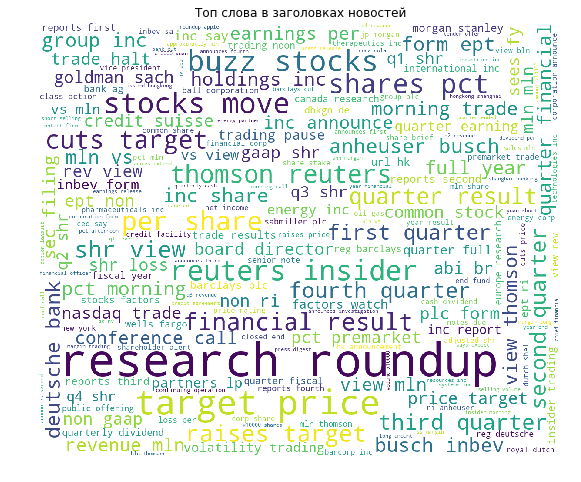

In [19]:
text = ' '.join(news_train_df['headline'].str.lower().values[-1000000:])
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Топ слова в заголовках новостей')
plt.axis("off")
plt.show()

In [20]:
news_train_df = news_train_df.loc[news_train_df['time'] >= '2010-01-01 22:00:00+0000']

In [21]:
news_train_df['provider'].value_counts().head(10)

RTRS    5517624
PRN      503267
BSW      472612
GNW      145309
MKW      129621
LSE       64250
HIIS      56489
RNS       39833
CNW       30779
ONE       25233
Name: provider, dtype: int64

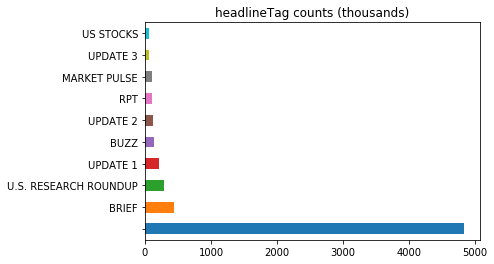

In [22]:
(news_train_df['headlineTag'].value_counts() / 1000)[:10].plot('barh');
plt.title('headlineTag counts (thousands)');

In [23]:
for i, j in zip([-1, 0, 1], ['негативными', 'нейтроальными', 'позитивными']):
    df_sentiment = news_train_df.loc[news_train_df['sentimentClass'] == i, 'assetName']
    print(f'Топ компаний с {j} новостями')
    print(df_sentiment.value_counts().head(5))
    print('')

Топ компаний с негативными новостями
Apple Inc                  22518
JPMorgan Chase & Co        20647
BP PLC                     19328
Goldman Sachs Group Inc    17955
Bank of America Corp       17704
Name: assetName, dtype: int64

Топ компаний с нейтроальными новостями
HSBC Holdings PLC    19462
Credit Suisse AG     14632
Deutsche Bank AG     12959
Barclays PLC         12414
Apple Inc            10994
Name: assetName, dtype: int64

Топ компаний с позитивными новостями
Apple Inc                19020
Barclays PLC             18051
Royal Dutch Shell PLC    15484
General Electric Co      14163
Boeing Co                14080
Name: assetName, dtype: int64



In [24]:
market_train_df['time_d'] = pd.to_datetime(market_train_df['time'], errors='coerce')

In [25]:
data = []
asset_df = market_train_df[(market_train_df['assetCode'] == 'AAPL.O') & (market_train_df['time_d'] > '2015-01-01') & (market_train_df['time_d'] < '2017-01-01')]

data.append(go.Scatter(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = asset_df['close'].values,
        name = asset
    ))
layout = go.Layout(dict(title = "Стоимость закрытия",
                  xaxis = dict(title = 'Месяц'),
                  yaxis = dict(title = 'Цена (USD)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [26]:
def plotAsset(assetCode1,date1,date2):
    data = []
    asset_df = market_train_df[(market_train_df['assetCode'] == assetCode1) & (market_train_df['time_d'] > date1) & (market_train_df['time_d'] < date2)]

    data.append(go.Scatter(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = asset_df['close'].values,
        name = asset
    ))
    layout = go.Layout(dict(title = "Стоимость закрытия",
                  xaxis = dict(title = 'Месяц'),
                  yaxis = dict(title = 'Цена (USD)'),
                  ),legend=dict(
                orientation="h"))
    py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [27]:
plotAsset('AAPL.O','2015-01-01','2017-01-01')

In [28]:
def Candlestick(assetCode1,date1,date2):

    asset_df = market_train_df[(market_train_df['assetCode'] == assetCode1) 
                  & (market_train_df['time'] > date1) 
                  & (market_train_df['time'] < date2)]
    
    asset_df['high'] = asset_df['open']
    asset_df['low'] = asset_df['close']

    for ind, row in asset_df.iterrows():
        if row['close'] > row['open']:
            asset_df.loc[ind, 'high'] = row['close']
            asset_df.loc[ind, 'low'] = row['open']

    trace1 = go.Candlestick(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        open = asset_df['open'].values,
        low = asset_df['low'].values,
        high = asset_df['high'].values,
        close = asset_df['close'].values
    )

    layout = dict(title = "График {}".format(assetCode1),
                  xaxis = dict(
                      title = 'Месяц',
                      rangeslider = dict(visible = False)
                  ),
                  yaxis = dict(title = 'Цена (USD)'))
    
    data = [trace1]

    py.iplot(dict(data=data, layout=layout), filename='basic-line')   

In [29]:
Candlestick('AAPL.O','2015-01-01','2017-01-01')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie